In [25]:
import sys
sys.path.append('..')
import os
import shutil
import torch

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy
%matplotlib notebook

from data import *
from model import Loop
from utils import generate_merlin_wav

from torch.autograd import Variable
from IPython.display import Audio
from nnmnkwii.metrics import *



In [26]:
data_path = os.path.abspath('../data/vctk/numpy_features')
norm_info = os.path.abspath('../data/vctk/norm_info/norm.dat')
    
train_dataset = NpzFolder(data_path)
valid_dataset = NpzFolder(data_path + '_valid')

In [27]:
#torch.cuda.set_device(0)
torch.cuda.device(0)
checkpoint = '../models/vctk'
weights = torch.load(checkpoint + '/bestmodel.pth', map_location=lambda storage, loc: storage)

args = torch.load(checkpoint + '/args.pth')
opt = args[0]
opt.noise = 0

model = Loop(opt)
model.load_state_dict(weights)
model.cuda();
model.eval();

In [45]:
ID = 5
txt, feat, _ = valid_dataset[8]

txt = Variable(txt.unsqueeze(1), volatile=True).cuda()
feat = Variable(feat.unsqueeze(1), volatile=True).cuda()
spkr = Variable(torch.LongTensor([ID]), volatile=True).cuda()

out, attn = model([txt, spkr], feat)
prediction = out.data.cpu().numpy()

feat = feat.data.cpu().numpy()
prediction = prediction[:, 0, :]
fea = feat[:, 0, :]

print("test MSE: ", np.mean(mean_squared_error(feat, prediction)))
generate_merlin_wav(prediction, "/tmp/gen", file_basename='test',
                    norm_info_file=norm_info, do_post_filtering=True)
Audio('/tmp/gen/test.wav')

/home/jaebok/miniconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/jaebok/miniconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/jaebok/miniconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


test MSE:  1.3203857672412223
DEBUG: data (302, 63)
output_file_name: /tmp/gen/test.cmp
feature:  mgc
DEBUG: data (302, 60)
output_file_name: /tmp/gen/test.mgc
feature:  lf0
DEBUG: data (302, 1)
output_file_name: /tmp/gen/test.lf0
feature:  bap
DEBUG: data (302, 1)
output_file_name: /tmp/gen/test.bap
DEBUG: feature writing is done.


{b'aa': 0, b'ae': 1, b'ah': 2, b'ao': 3, b'aw': 4, b'ax': 5, b'ay': 6, b'b': 7, b'ch': 8, b'd': 9, b'dh': 10, b'eh': 11, b'er': 12, b'ey': 13, b'f': 14, b'g': 15, b'hh': 16, b'i': 17, b'ih': 18, b'iy': 19, b'jh': 20, b'k': 21, b'l': 22, b'm': 23, b'n': 24, b'ng': 25, b'ow': 26, b'oy': 27, b'p': 28, b'pau': 29, b'r': 30, b's': 31, b'sh': 32, b'ssil': 33, b't': 34, b'th': 35, b'uh': 36, b'uw': 37, b'v': 38, b'w': 39, b'y': 40, b'z': 41}
{0: b'aa', 1: b'ae', 2: b'ah', 3: b'ao', 4: b'aw', 5: b'ax', 6: b'ay', 7: b'b', 8: b'ch', 9: b'd', 10: b'dh', 11: b'eh', 12: b'er', 13: b'ey', 14: b'f', 15: b'g', 16: b'hh', 17: b'i', 18: b'ih', 19: b'iy', 20: b'jh', 21: b'k', 22: b'l', 23: b'm', 24: b'n', 25: b'ng', 26: b'ow', 27: b'oy', 28: b'p', 29: b'pau', 30: b'r', 31: b's', 32: b'sh', 33: b'ssil', 34: b't', 35: b'th', 36: b'uh', 37: b'uw', 38: b'v', 39: b'w', 40: b'y', 41: b'z'}


<IPython.core.display.Javascript object>


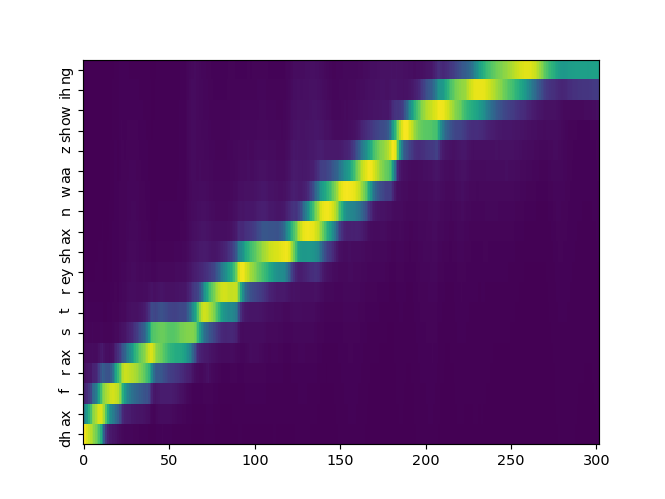

In [22]:
def plot(data, labels, dict_file):
    labels_dict = dict_file
    print(labels_dict)
    
    idx2labels_dict = {k: v for k, v in enumerate(labels_dict)}
    
    print(idx2labels_dict)
    labels = [idx2labels_dict[x].decode('latin-1') for x in labels]

    axarr = plt.subplot()
    axarr.imshow(data.T, aspect='auto', origin='lower', interpolation='nearest', cmap=cm.viridis)
    axarr.set_yticks(numpy.arange(0, len(data.T)))
    axarr.set_yticklabels(labels, rotation=90)
  


plot(attn.squeeze().data.cpu().numpy(), txt[:,0].squeeze().data.tolist(), valid_dataset.dict)

In [53]:
generate_merlin_wav(feat, "/tmp/gen", file_basename='test',
                    norm_info_file=norm_info, do_post_filtering=False)
Audio('/tmp/gen/test.wav')

DEBUG: data (302, 1, 63)
output_file_name: /tmp/gen/test.cmp
feature:  mgc
DEBUG: data (302, 60)
output_file_name: /tmp/gen/test.mgc
feature:  lf0
DEBUG: data (302, 1)
output_file_name: /tmp/gen/test.lf0
feature:  bap
DEBUG: data (302, 1)
output_file_name: /tmp/gen/test.bap
DEBUG: feature writing is done.


In [52]:
import pyworld
import pysptk
import librosa
import IPython

from IPython.display import Audio

fl=1024
sr=16000
pf_coef = 1.4
fw_alpha = 0.58
co_coef = 511
frame_period = 5



fid = open(norm_info, 'rb')
cmp_info = numpy.fromfile(fid, dtype=numpy.float32)
fid.close()
cmp_info = cmp_info.reshape((2, -1))
cmp_mean = cmp_info[0, ]
cmp_std = cmp_info[1, ]

print("cmp_mean", cmp_mean.shape)
print("cmp_mean", cmp_mean)
print("cmp_std", cmp_std.shape)
print("cmp_std", cmp_std)


n_feat = feat * cmp_std + cmp_mean
    
o_feat = feat.reshape((n_feat.shape[0], n_feat.shape[2]))
print("o_feat:, ", o_feat.shape)
mgc = o_feat[:, 2:62]
lf0 = o_feat[:, 1:2].reshape((lf0.shape[0], 1))
bap = o_feat[:, 0:1].reshape((bap.shape[0], 1))
vuv = o_feat[:, 62].reshape((vuv.shape[0], 1))

print("mgc:, ", mgc.shape)
print("lf0:, ", lf0.shape)
print("bap:, ", bap.shape)
print("vuv:, ", vuv.shape)

'''
print("mgc:, ", mgc[100])
print("lf0:, ", lf0[100])
print("bap:, ", bap[100])
print("vuv:, ", vuv[100])
'''

spectrogram = pysptk.mc2sp(mgc, fftlen=fl, alpha=fw_alpha)
aperiodicity = pyworld.decode_aperiodicity(bap.astype(np.float64), sr, fl)
f0 = lf0.copy()
f0[vuv < 0.5] = 0
f0[np.nonzero(f0)] = np.exp(f0[np.nonzero(f0)])

print("f0:, ", f0)
print("vuv:, ", vuv)


generated_waveform = pyworld.synthesize(f0.flatten().astype(np.float64),
                                        spectrogram.astype(np.float64),
                                        aperiodicity.astype(np.float64),
                                        sr, frame_period)
IPython.display.display(Audio(generated_waveform, rate=sr))

cmp_mean (63,)
cmp_mean [ 5.1143003   2.1099389  -0.02673552  0.68151593 -0.28616902  0.18193108
 -0.20691416  0.21194716  0.01920242  0.1363248  -0.02648539  0.03443318
 -0.09537376  0.06285409 -0.05997007  0.0716436  -0.10657702  0.10377043
 -0.11315625  0.10582404 -0.10585444  0.09515836 -0.09871352  0.08674598
 -0.09710813  0.08883245 -0.089407    0.0740217  -0.08494064  0.07820421
 -0.07292877  0.06681186 -0.06833059  0.06338202 -0.06055671  0.06154745
 -0.06259225  0.06093474 -0.05632448  0.05181655 -0.05027333  0.0488576
 -0.04614096  0.04256589 -0.0396636   0.03785083 -0.03507471  0.03264595
 -0.02901894  0.02778493 -0.02483662  0.02358763 -0.01948546  0.01822413
 -0.01610932  0.01771195 -0.01793332  0.01815702 -0.01470372  0.01076495
  0.6452634   5.146817   -5.2183404 ]
cmp_std (63,)
cmp_std [1.4401975  1.1058221  0.7258239  0.4402437  0.49886382 0.3370036
 0.30366394 0.27782956 0.24459463 0.25433686 0.20491306 0.19968402
 0.17654261 0.17754401 0.16663234 0.14516507 0.1446923

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)